# **Data Visualization**

## Objectives

* Answer Business Requirement 1:
    * The client is interested in conducting a study to visually differentiate a healthy cherry leaf from one with powdery mildew.

## Inputs

* inputs/cherry_leaves/cherry-leaves/train
* inputs/cherry_leaves/cherry-leaves/validation
* inputs/cherry_leaves/cherry-leaves/test

## Outputs

* Image shape embeddings pkl file
* Mean and variability of images per label plot
* Plot to distinguish the difference between leaves with and without mildew
* Image montage for each label

## Additional Comments

* No additional comments 



---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/milestone-project-mildew-detection-in-cherry-leaves/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/milestone-project-mildew-detection-in-cherry-leaves'

---

# Set the Input and Output directories

https://github.com/Code-Institute-Solutions/WalkthroughProject01/blob/main/jupyter_notebooks/02%20-%20DataVisualization.ipynb

## Set the input directories

Create variables for the data directory path and its subfolders paths 

In [4]:
# https://github.com/Code-Institute-Solutions/WalkthroughProject01/blob/main/jupyter_notebooks/02%20-%20DataVisualization.ipynb

my_data_dir = '/workspace/milestone-project-mildew-detection-in-cherry-leaves/inputs/cherry_leaves/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set the output directories

Create folders and subfolders for storing the results of the research

In [5]:
# https://github.com/Code-Institute-Solutions/WalkthroughProject01/blob/main/jupyter_notebooks/02%20-%20DataVisualization.ipynb

version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


# Import the necessary libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

---

# Labels Distribution


The labels are assessed based on the folder names at the folder of each set (Train, Test, Validation).

In [7]:
sets = os.listdir(my_data_dir)
label_list = []
for set in sets:
    labels=os.listdir(my_data_dir + '/' + set)
    for item in labels:
        if item not in label_list:
            label_list.append(item)

print(label_list)

['healthy', 'powdery_mildew']


The name of the set, the label and its frequency is stored in a DataFrame

In [8]:
# https://learn.codeinstitute.net/courses/course-v1:code_institute+CI_DA_ML+2021_Q4/courseware/1f851533cd6a4dcd8a280fd9f37ef4e2/b6cf6ce506324501bcf6aa0f31e0c20c/

freq_list = []
for folder in sets:
  for label in label_list:
    freq_list.append(
        pd.Series({'Set': folder,
                        'Label': label,
                        'Frequency':len(os.listdir(my_data_dir + '/' + folder + '/' + label))}
                  ),
        )
    

df_freq = pd.DataFrame(freq_list)
df_freq

,Set,Label,Frequency
0,test,healthy,422
1,test,powdery_mildew,422
2,train,healthy,1472
3,train,powdery_mildew,1472
4,validation,healthy,210
5,validation,powdery_mildew,210


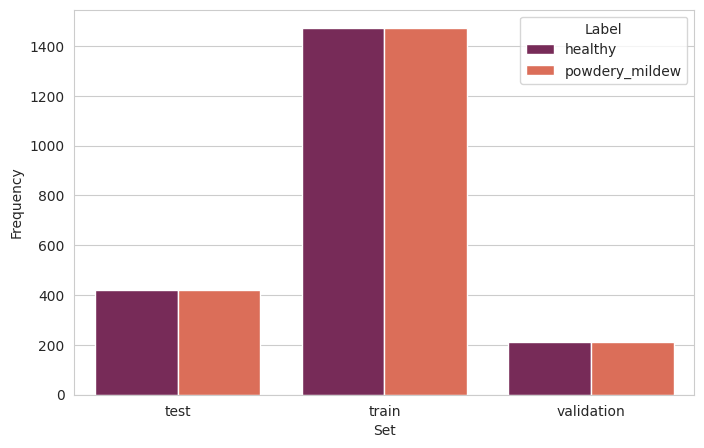

In [9]:
# https://learn.codeinstitute.net/courses/course-v1:code_institute+CI_DA_ML+2021_Q4/courseware/1f851533cd6a4dcd8a280fd9f37ef4e2/b6cf6ce506324501bcf6aa0f31e0c20c/

sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label', palette='rocket')
plt.show()

---

## Image shape

### Calculate the average image size on the train set

Create two lists, one storing the image height and the other the image width of the images in the train folder.

In [10]:
# https://github.com/Code-Institute-Solutions/WalkthroughProject01/blob/main/jupyter_notebooks/02%20-%20DataVisualization.ipynb

dim1, dim2 = [], []
for label in label_list:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)  # image height
        dim2.append(d2)  # image width
dim1_mean = int(sum(dim1) / len(dim1))
dim2_mean = int(sum(dim2) / len(dim2))
print(f'The average height is: {dim1_mean}px')
print(f'The average width is: {dim2_mean}px')

The average height is: 256px
The average width is: 256px


As specified in the Business Requirement 2, the image shape of 256x256 will likely result in a trained model larger than the 100Mb limit. Thus the 100x100 shape will be used. This shape should reduce the image size without compromising the performance. 

In [12]:
image_shape = (100, 100, 3)
image_shape

(100, 100, 3)

Save the image shape embeddings

In [11]:
# https://github.com/Code-Institute-Solutions/WalkthroughProject01/blob/main/jupyter_notebooks/02%20-%20DataVisualization.ipynb

joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

NameError: name 'image_shape' is not defined

---

## Average Image and Image Variability per Label



Function that loops over a folder finding all the labels subfolders. For each label, all the images will be loaded, resized to the image_shape values, and stored into arrays.

In [20]:
# https://learn.codeinstitute.net/courses/course-v1:code_institute+CI_DA_ML+2021_Q4/courseware/1f851533cd6a4dcd8a280fd9f37ef4e2/b6cf6ce506324501bcf6aa0f31e0c20c/

from tensorflow.keras.preprocessing import image

def load_image_as_array(my_data_dir, new_size=(100,100), images_amount = 100):
  
  X, y = np.array([], dtype='int'), np.array([], dtype='object')

  for label in label_list:
    counter = 0
    for image_filename in os.listdir(my_data_dir + '/' + label):
      if counter < images_amount:
        
        img = image.load_img(my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
        if image.img_to_array(img).max() > 1: 
          img_resized = image.img_to_array(img) / 255
        else: 
          img_resized = image.img_to_array(img)
        
        X = np.append(X, img_resized).reshape(-1, new_size[0], new_size[1], img_resized.shape[2])
        y = np.append(y, label)
        counter += 1

  return X, y

Call the load_image_as_array function on the images in the train directory using the image_shape sizes.

In [38]:
X, y = load_image_as_array(train_path, image_shape, images_amount = 30)
print(X.shape, y.shape)

(60, 100, 100, 3) (60,)


Function to calculate the average image and the image variability for each label, then display the average image and image variability in a Figure.

In [41]:
# https://learn.codeinstitute.net/courses/course-v1:code_institute+CI_DA_ML+2021_Q4/courseware/1f851533cd6a4dcd8a280fd9f37ef4e2/b6cf6ce506324501bcf6aa0f31e0c20c/

def image_avg_and_variability_data_as_array(X, y, figsize=(12,5)):
  for label_to_display in np.unique(y):
    
    # boolean mask to process only the images of a certain label
    y = y.reshape(-1,1,1)
    boolean_mask = np.any(y==label_to_display,axis=1).reshape(-1)
    arr = X[boolean_mask]

    avg_image = np.mean(arr, axis=0)
    image_var = np.std(arr, axis=0)
    print('-' * 60)
    print(f'{label_to_display} cherry leaves'.upper())
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    axes[0].set_title('Average Image')
    axes[0].imshow(avg_image, cmap='gray')
    axes[1].set_title('Image Variability')
    axes[1].imshow(image_var, cmap='gray')
    plt.show()
    print('\n')



------------------------------------------------------------
HEALTHY CHERRY LEAVES


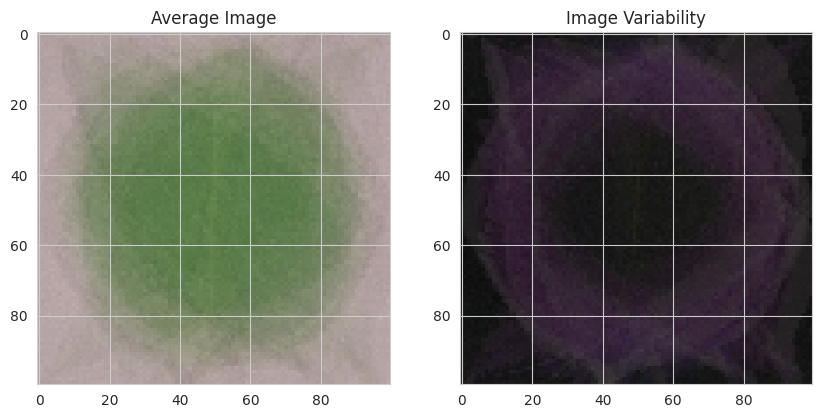



------------------------------------------------------------
POWDERY_MILDEW CHERRY LEAVES


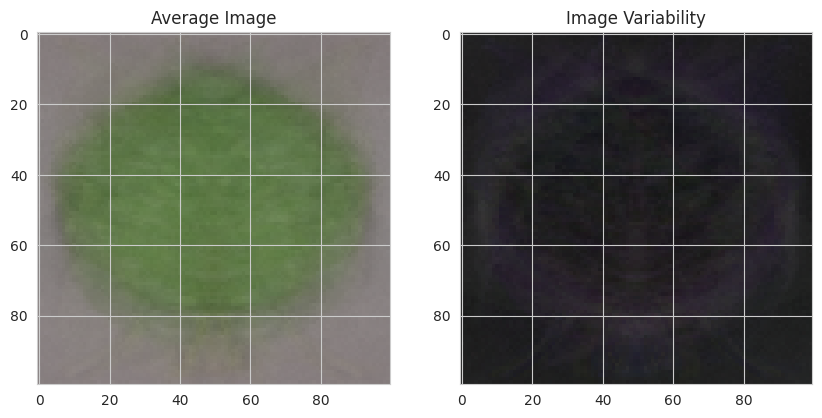

In [42]:
image_avg_and_variability_data_as_array(X=X, y=y, figsize=(10,8))

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* If you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
    # create here your folder
    # os.makedirs(name='')
except Exception as e:
    print(e)
